## In this notebook, we will
1. Build a NN to predict the reduction potential of molecules.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import statsmodels.api as sm
import time

In [5]:
#Keras/TensorFlow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Softmax
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

#Keras image processing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [6]:
#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras specials
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

## Load csv files into DataFrames

In [7]:
features=pd.read_csv('Data/features_train.csv',index_col=0)
target=pd.read_csv('Data/target_train.csv',index_col=0)['ERed']

features_std = StandardScaler().fit_transform(features)

In [10]:
features_std=tf.convert_to_tensor(features_std,dtype=tf.float64)
target=tf.convert_to_tensor(target,dtype=tf.float64)

In [15]:
num_dens_layers=4     
n_nodes=[64, 32,16, 1]
learning_rate=1e-3

model = Sequential()
model.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu')) # first hidden layer
# model.add(Dropout(0.5))
for i in range(1,num_dens_layers): # loop through the rest of hidden layers
    model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    

model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
116/116 [==============================] - 1s 5ms/step - loss: 0.5691 - mean_absolute_error: 0.5691 - val_loss: 0.1371 - val_mean_absolute_error: 0.1371 - lr: 0.0010
Epoch 2/50
116/116 [==============================] - 0s 3ms/step - loss: 0.1118 - mean_absolute_error: 0.1118 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001 - lr: 0.0010
Epoch 3/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0898 - mean_absolute_error: 0.0898 - val_loss: 0.0845 - val_mean_absolute_error: 0.0845 - lr: 0.0010
Epoch 4/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0787 - mean_absolute_error: 0.0787 - val_loss: 0.0834 - val_mean_absolute_error: 0.0834 - lr: 0.0010
Epoch 5/50
116/116 [==============================] - 0s 4ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.0797 - val_mean_absolute_error: 0.0797 - lr: 0.0010
Epoch 6/50
116/116 [==============================] - 0s 4ms/step - loss: 0.0696 - mean_absolute_error: 0.0696 - va

Epoch 45/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0511 - mean_absolute_error: 0.0511 - val_loss: 0.0596 - val_mean_absolute_error: 0.0596 - lr: 8.1000e-04
Epoch 46/50
111/116 [===========================>..] - ETA: 0s - loss: 0.0518 - mean_absolute_error: 0.0518
Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.
116/116 [==============================] - 0s 3ms/step - loss: 0.0518 - mean_absolute_error: 0.0518 - val_loss: 0.0585 - val_mean_absolute_error: 0.0585 - lr: 8.1000e-04
Epoch 47/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0509 - mean_absolute_error: 0.0509 - val_loss: 0.0578 - val_mean_absolute_error: 0.0578 - lr: 7.2900e-04
Epoch 48/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0510 - mean_absolute_error: 0.0510 - val_loss: 0.0583 - val_mean_absolute_error: 0.0583 - lr: 7.2900e-04
Epoch 49/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0500 - mean_absolute_e

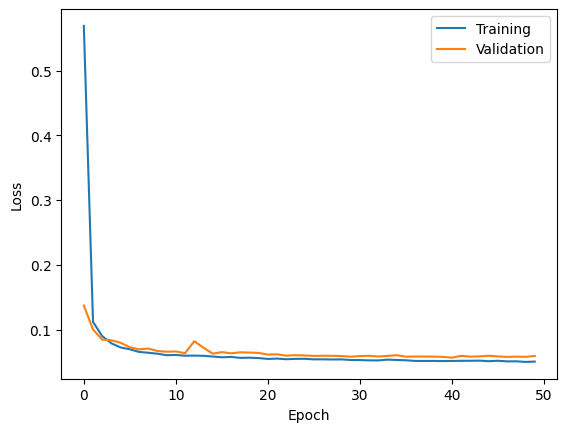

In [16]:
%%time

with tf.device('/cpu:0'):

    redlr=ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.9, patience=5, min_lr=0, verbose=1)

    history=model.fit(features_std, target, epochs=50, batch_size=32, validation_split = 0.15, callbacks=redlr, verbose=True)

    train_err=history.history['mean_absolute_error']

    val_err=history.history['val_mean_absolute_error']

    plt.figure()
    plt.plot(train_err, label='Training')
    plt.plot(val_err, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

137/137 [==============================] - 0s 2ms/step


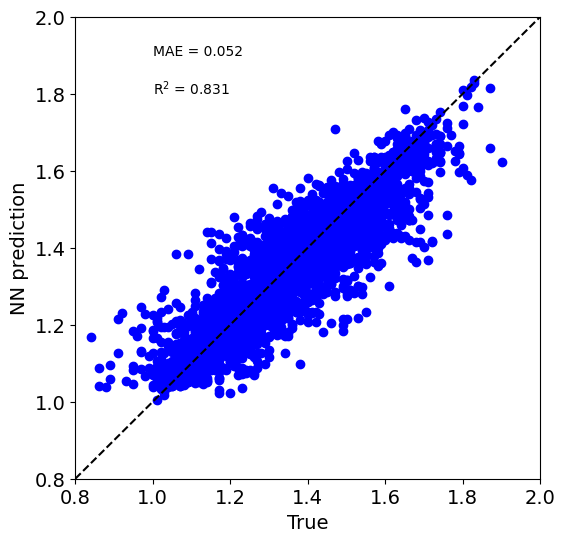

In [17]:
target_nn=model.predict(features_std)
train_mae=mean_absolute_error(target,target_nn)
train_rmse=np.sqrt(mean_squared_error(target,target_nn))
train_r2=r2_score(target,target_nn)

plt.figure(figsize=(6,6))
plt.scatter(target,target_nn,c='b')
plt.plot([0.8,2],[0.8,2],ls='--',c='k')
plt.xlim([0.8,2])
plt.ylim([0.8,2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('NN prediction',fontsize=14)
plt.text(1,1.9,'MAE = '+str(np.round(train_mae,3)))
plt.text(1,1.8,'R$^2$ = '+str(np.round(train_r2,3)))
plt.show()

## Save NN model

In [18]:
!mkdir -p NN_model
model.save('Models/NN_model/')

INFO:tensorflow:Assets written to: Models/NN_model/assets


In [19]:
ls Models/NN_model

assets/  keras_metadata.pb  saved_model.pb  variables/


In [20]:
NN_model = tf.keras.models.load_model('Models/NN_model/')

# Check its architecture
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


## Save NN model and weights as HDF5

In [21]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
